In [1]:
import numpy as np
import pandas as pd
import hiive.mdptoolbox 
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import gym
import matplotlib.pyplot as plt
import time
from collections import Counter
import seaborn as sns


Bad key "“backend" on line 1 in
/Users/bhkash/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [208]:
def analyze_param_policy(P, R, solver_type = "PI",
                 param = "gamma", param_range = [0.97, 0.98, 0.99,0.993], max_iter = 500, gamma = 0.99, epsilon_V = 0.01, display = True
                        ,epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.99,
                        alpha = 0.1, alpha_decay = 0.99, alpha_min=0.001, size = "4x4", fig_name = ""):
    
    
    
    graph_params = ["Mean V", "Max V", "Error", "Time"]
    if solver_type == "PI":
        solver = lambda dict_args: hiive.mdptoolbox.mdp.PolicyIteration(**dict_args)
        args = {"transitions":P, "reward":R, "gamma":gamma, "max_iter":max_iter, "skip_check":True}
    elif solver_type == "VI":
        solver = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
        args = {"transitions":P, "reward":R, "gamma":gamma,"epsilon":epsilon_V, "max_iter":max_iter, "skip_check":True}
    elif solver_type == "Q":
        solver_type = "QL"
        solver = lambda dict_args: hiive.mdptoolbox.mdp.QLearning(**dict_args)
        
        args = {"transitions":P, "reward":R, "gamma":gamma,
                "epsilon":epsilon, "epsilon_min": epsilon_min, "epsilon_decay": epsilon_decay, 
                "alpha": alpha, "alpha_decay": alpha_decay, "alpha_min":alpha_min,
                "n_iter":max_iter, "skip_check":True}
        graph_params = ["Mean V", "Max V", "Alpha","Epsilon", "Error", "Time"]
    else:
        throw("Wrong solver Type")
    
    df = pd.DataFrame(index = range(max_iter))
    for val in param_range:
        np.random.seed(252)
        args[param] = val 
        mdp = solver(args)
        #print(mdp)
        mdp.run()
        df_temp = pd.DataFrame(mdp.run_stats)
        #print(df_temp)
        df_temp = df_temp.set_index("Iteration")
        df_temp = df_temp.add_suffix("_"+ param+ "_" + str(val) + "_" + solver_type)
        
        df = df.join(df_temp)
    df.ffill(inplace= True)
    
    if display:
        plot_param(df, title =solver_type + " - " + param + " " + size, params =graph_params, fig_name = fig_name)
        
    print(df.shape)    
    return df

def plot_param(df, params = ["Mean V", "Max V", "Error", "Time"], title=None, fig_name = ""):      
    print(df.shape)
    for param in params:
        fitness_col = [col for col in df if col.startswith(param)]
        df_fitness = df[fitness_col]
        df_fitness.columns = [col.replace(param+'_', '') for col in df_fitness.columns]
        #print(df_fitness.columns)
        df_fitness.plot()
        
        if param == "Mean V":
            param = "Mean Utility"
            
        if param == "Max V":
            param = "Max Utility"
        
        if fig_name != "":
            fig_name = fig_name
        if title != None:
            heading = title
        else:
            heading = param
        plt.title(heading, fontdict={'fontsize': 15, 'fontweight': 'heavy'})
        plt.xlabel("Iterations")

        plt.ylabel(param) 
        plt.legend()
        plt.grid()
        plt.show()
        
def plot_run_stats(mdp, title = "MDP", params = ["Mean V", "Max V", "Error", "Time"]):
    df = pd.DataFrame(mdp.run_stats)
    df = df.set_index("Iteration")
    plot_param(df, params, title)
        

In [204]:
def plotIterationGraph(df, plot1_name, plot2_name, title = "Title"):
    
    plot1_cols = [col for col in df if col.startswith(plot1_name)]
    plot2_cols = [col for col in df if col.startswith(plot2_name)]
    #df[plot1_cols].plot()
    fig, axs = plt.subplots(2)
    fig.suptitle(title,fontsize = 15, fontweight = 'heavy')
    
    df[plot1_cols].plot(ax= axs[0], legend = False, grid = True)
    axs[0].set_ylabel("Mean Utility")
    
    df[plot2_cols].plot(ax= axs[1])
    axs[1].set_xlabel("Iterations")
    axs[1].set_ylabel(plot2_name)
    plt.grid()
    plt.show()

In [232]:

def frozen_lake_color():
    return {
        b'S': 'green',
        b'F': 'skyblue',
        b'H': 'black',
        b'G': 'gold',
    }

def directions_arrows():
    return {
        3: '⬆',
        2: '➡',
        1: '⬇',
        0: '⬅'
    }

import math

def plot_policy_map(trained_policy , env, title = "Heat Map", showUtility = False):
    policy = trained_policy.policy
    V = trained_policy.V
    # Plot heatmap
    flat_map = [item for sublist in env.unwrapped.desc for item in sublist] 
    policy_map = zip(policy, flat_map, V)
    labels = []
    font_size = 20
    for policy, square, utility in policy_map:
        annot = ""
        if square == b'S':
            annot = directions_arrows()[policy] + " (S)"
        elif square == b'H':
            annot = directions_arrows()[policy] + " (H)"
        elif square == b'G':
            annot = directions_arrows()[policy] + " (G)"
        else:
            annot = directions_arrows()[policy]
        if showUtility:
            font_size = 12
            annot = annot + " " + str('%.1f' % utility)
        labels.append(annot)
            
    length = int(math.sqrt(len(labels)))
    labels = np.array(labels).reshape(length,length)

    fig, ax = plt.subplots(figsize=(3*length/2, length))
    g = sns.heatmap(np.array(V).reshape(length, length), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":font_size, "fontweight":'heavy'}, ax = ax)
    ax.tick_params(labelsize=20)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=15)
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    plt.show()
    
def extract_P_R_from_OpenAI(mapname):
    
#     if mapname == "FrozenLake8x8-v0":
#         np.random.seed(0)
#         flrmap = generate_random_map(size=8, p=0.8)
#         env = gym.make("FrozenLake-v0", desc=flrmap, is_slippery = True)
#     else:
#         env = gym.make(mapname)
    env = gym.make(mapname)
    env.reset()

    P = np.zeros([env.nA, env.nS, env.nS])
    R = np.zeros([env.nS, env.nA])
    
    for s in range(env.nS):
        for a in range(env.nA):
            transitions = env.P[s][a]
            for p_trans, next_s, reward, _ in transitions:
                P[a,s,next_s] += p_trans
                R[s,a] = reward
            P[a,s,:] /= np.sum(P[a,s,:])

    if mapname == "FrozenLake-v0":
        R[14,1] = 0
        R[14,2] = 1
        R[15] = 1
    if mapname == "FrozenLake8x8-v0":
        R[55,0] = 0
        R[55,1] = 1
        R[62,1] = 0
        R[62,2] = 1
        R[63] = 1
        
    env.render()
    return P,R, env
    

In [14]:
    
def tile():
    return {
    b'S': 'S',
    b'F': 'F',
    b'H': 'H',
    b'G': 'G',
    }


def plot_policy_map_old(title, policy, map_desc, color_map, direction_map):
#     policy = np.array(policy)
#     policy = policy.reshape(4,4)
    fig = plt.figure()
    ax = fig.add_subplot(111, xlim=(0, policy.shape[1]), ylim=(0, policy.shape[0]))
    font_size = 'x-large'
    if policy.shape[1] > 16:
        font_size = 'small'
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    for i in range(policy.shape[0]):
        for j in range(policy.shape[1]):
            y = policy.shape[0] - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1)
            p.set_facecolor(color_map[map_desc[i,j]])
            
            ax.add_patch(p)

            text = ax.text(x+0.5, y+0.5, tile()[map_desc[i,j]], weight='bold', size=20,
                           horizontalalignment='center', verticalalignment='center', color='w')


    plt.axis('off')
    plt.xlim((0, policy.shape[1]))
    plt.ylim((0, policy.shape[0]))
    plt.tight_layout()
    plt.show()

    return (plt)

# Frozen Lake

In [7]:
P_fl_small, R_fl_small, env_small = extract_P_R_from_OpenAI("FrozenLake-v0")
P_fl, R_fl = P_fl_small, R_fl_small
P_fl_large, R_fl_large, env_large = extract_P_R_from_OpenAI("FrozenLake8x8-v0")                                                      


SFFF
FHFH
FFFH
HFFG

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG


In [11]:
vi = hiive.mdptoolbox.mdp.ValueIteration(P_fl, R_fl, gamma = 0.99, max_iter=500)
vi.run()
vi.policy

(0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0)

In [15]:
pi_large = hiive.mdptoolbox.mdp.PolicyIteration(P_fl_large, R_fl_large, gamma = 0.99, max_iter=1000)
pi_large.run()
test = pi_large.policy

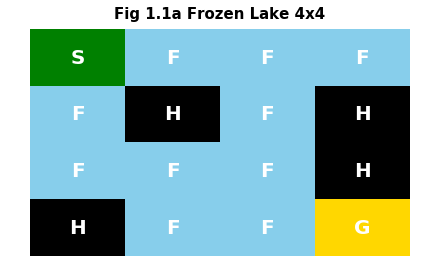

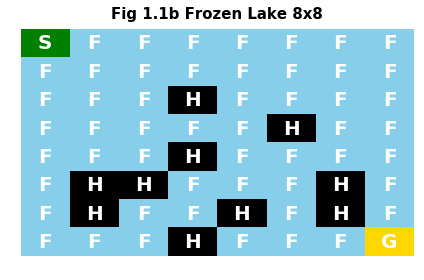

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [233]:
li = np.array(vi.policy)
plot_policy_map_old('Fig 1.1a Frozen Lake 4x4',li.reshape(4,4),env_small.env.desc,frozen_lake_color(),directions_arrows())

li =  np.array(pi_large.policy)
plot_policy_map_old('Fig 1.1b Frozen Lake 8x8',li.reshape(8,8),env_large.env.desc,frozen_lake_color(),directions_arrows())

# PI

(10, 28)


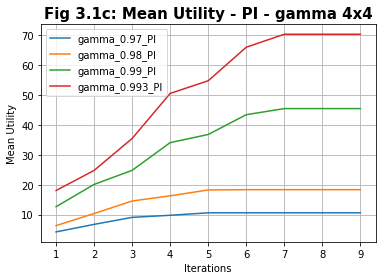

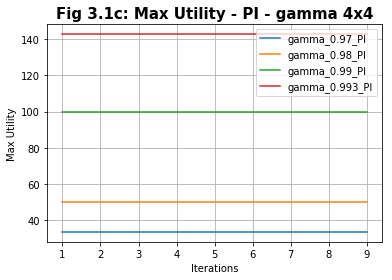

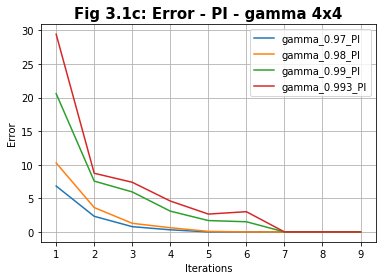

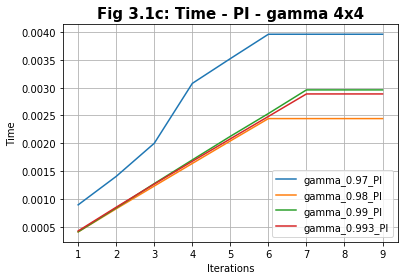

(10, 28)


In [44]:
results = analyze_param_policy(P_fl, R_fl, max_iter = 10, fig_name = "Fig 3.1c")

(10, 28)


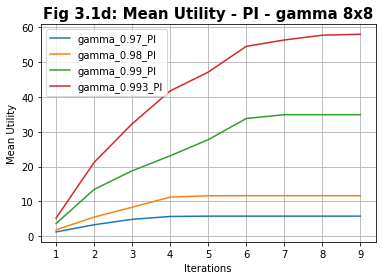

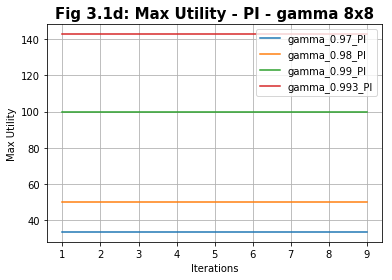

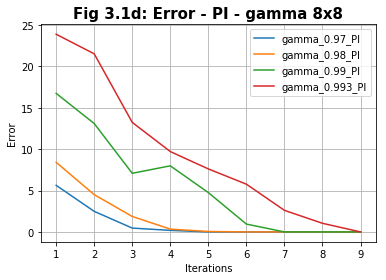

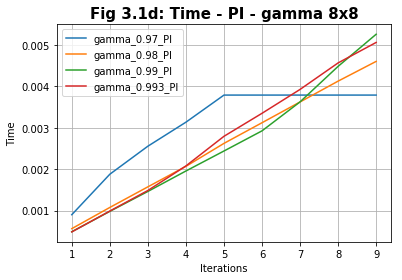

(10, 28)


In [48]:
results = analyze_param_policy(P_fl_large, R_fl_large, max_iter = 10, fig_name = "Fig 3.1d", size = "8x8")

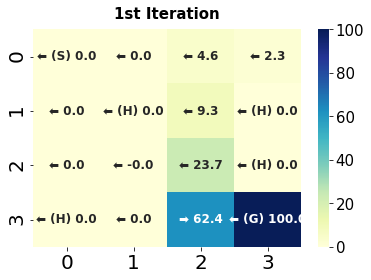

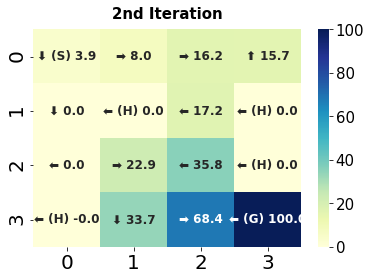

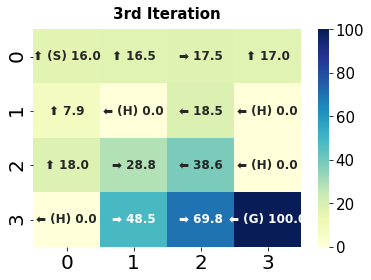

In [49]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=1)
pi.run()
pi.policy
plot_policy_map(pi, env_small, "1st Iteration", showUtility=True)

pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=2)
pi.run()
pi.policy
plot_policy_map(pi, env_small, "2nd Iteration", showUtility=True)

pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=3)
pi.run()
pi.policy
plot_policy_map(pi, env_small, "3rd Iteration", showUtility=True)

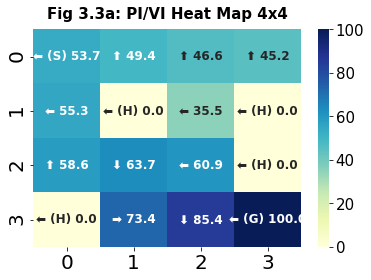

In [63]:
pi = hiive.mdptoolbox.mdp.PolicyIteration(P_fl, R_fl, gamma = 0.99, max_iter=100)
pi.run()
pi.policy

plot_policy_map(pi, env_small, "Fig 3.3a: PI/VI Heat Map 4x4", showUtility=True)

# VI

(1000, 28)


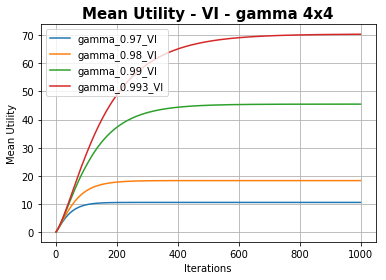

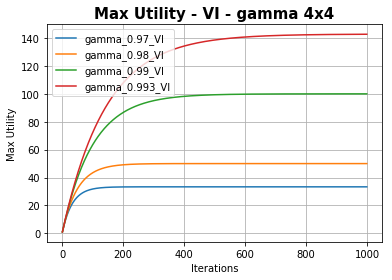

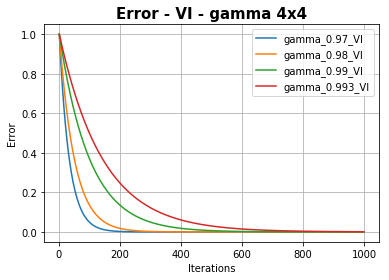

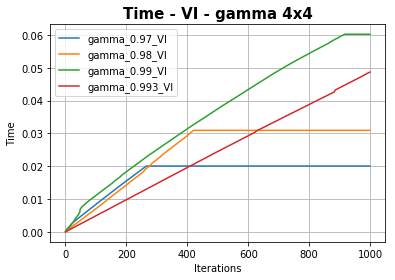

(1000, 28)


In [56]:
results = analyze_param_policy(P_fl, R_fl, solver_type="VI", max_iter = 1000 )

(1200, 28)


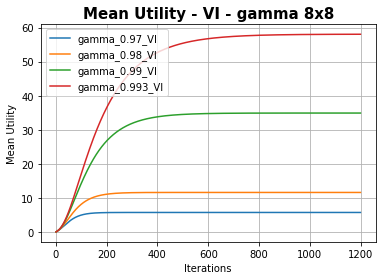

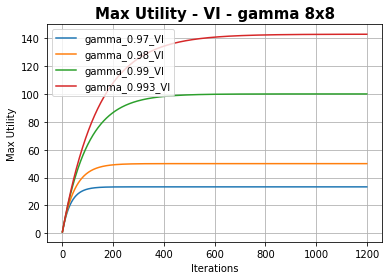

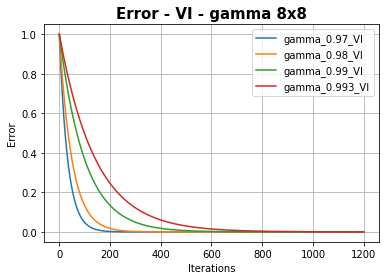

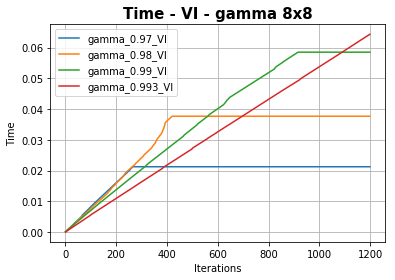

(1200, 28)


In [61]:
results = analyze_param_policy(P_fl_large, R_fl_large, solver_type="VI", max_iter = 1200 , size = "8x8")

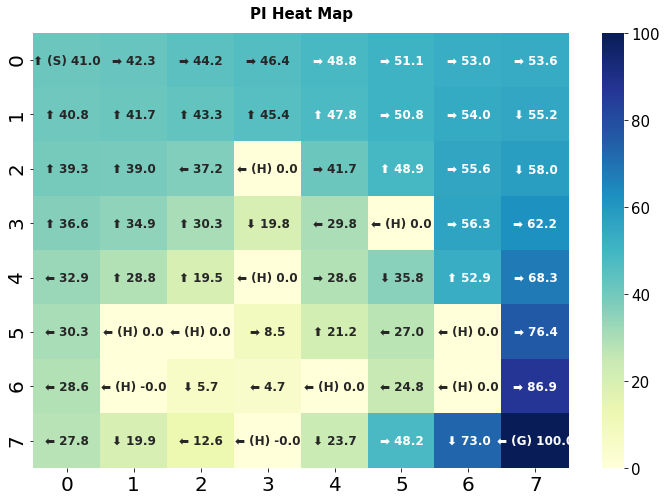

In [65]:
pi_large = hiive.mdptoolbox.mdp.PolicyIteration(P_fl_large, R_fl_large, gamma = 0.99, max_iter=1000)
pi_large.run()
test = pi_large.policy
plot_policy_map(pi_large, env_large, "PI Heat Map", showUtility = True)

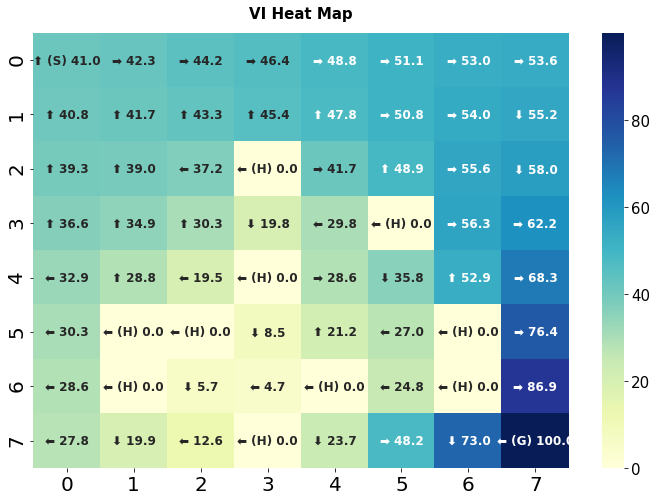

In [66]:
vi_large = hiive.mdptoolbox.mdp.ValueIteration(P_fl_large, R_fl_large, gamma = 0.99, epsilon= 0.00001, max_iter=5000)
test=vi_large.run()
plot_policy_map(vi_large, env_large, "VI Heat Map", showUtility=True)

# QL

(500000, 40)


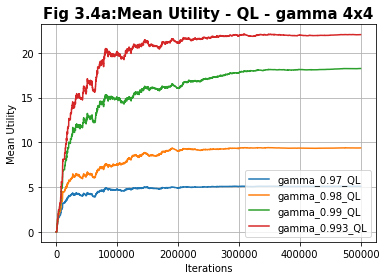

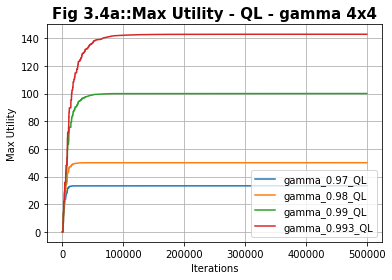

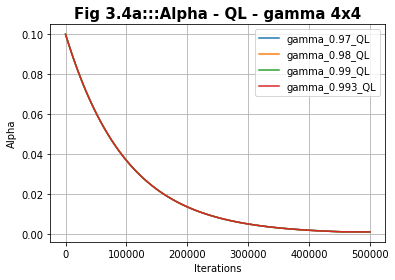

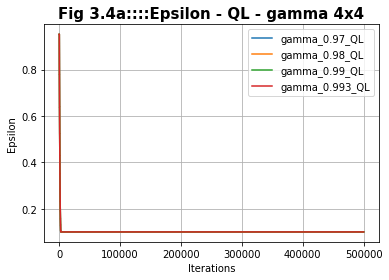

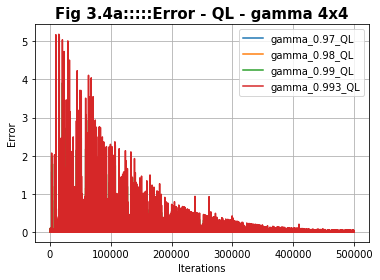

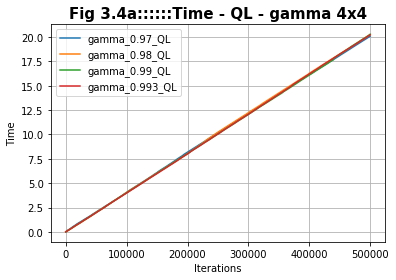

(500000, 40)


In [72]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               alpha_decay = 0.99999, fig_name="Fig 3.4a")

(500000, 50)


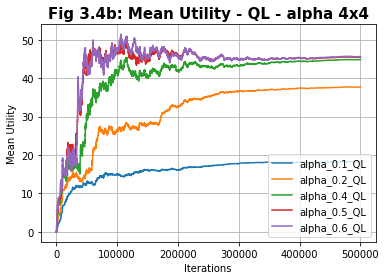

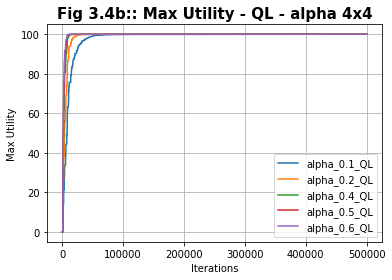

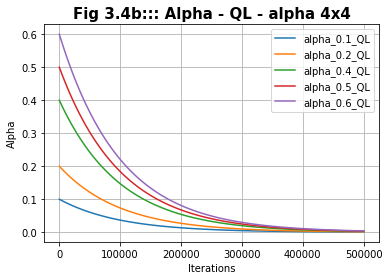

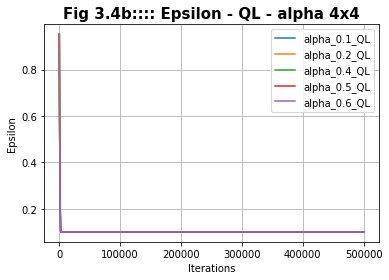

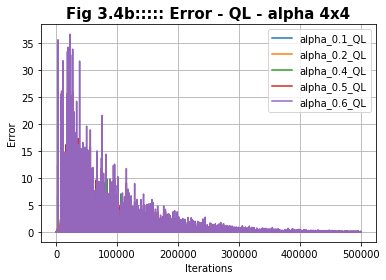

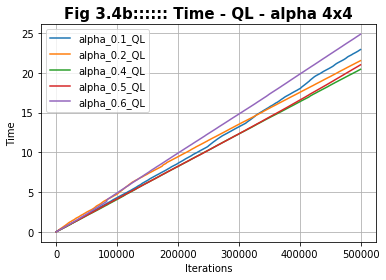

(500000, 50)


In [74]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.1, 0.2,0.4, 0.5, 0.6], alpha_decay = 0.99999, fig_name="Fig 3.4b")

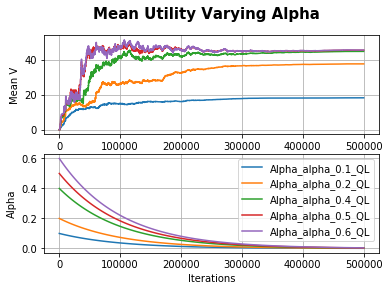

In [76]:
plotIterationGraph(results, "Mean V", "Alpha", "Mean Utility Varying Alpha")

(500000, 50)


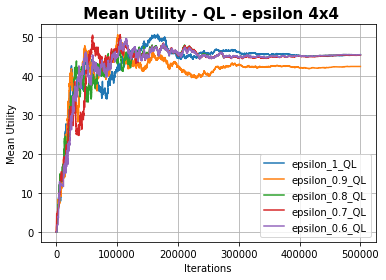

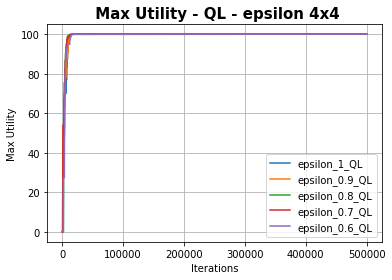

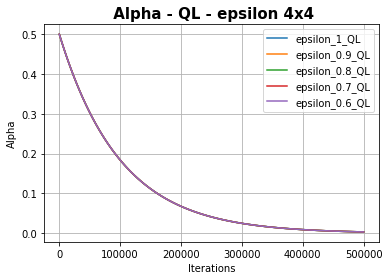

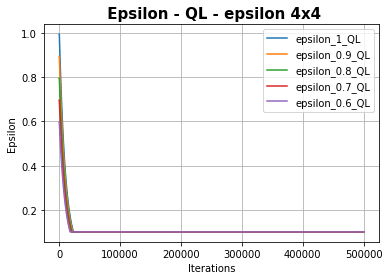

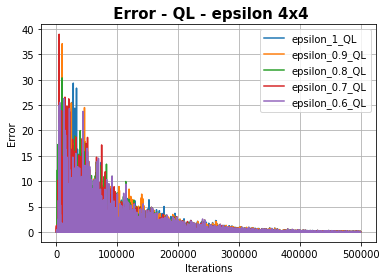

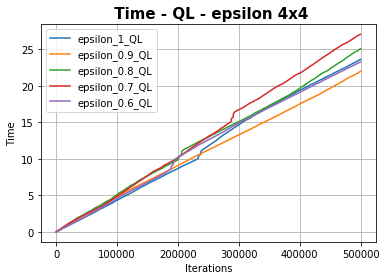

(500000, 50)


In [77]:
results_epsilon = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999,
                               param = "epsilon", param_range = [1, 0.9, 0.8, 0.7, 0.6], alpha = 0.5)

(500000, 40)


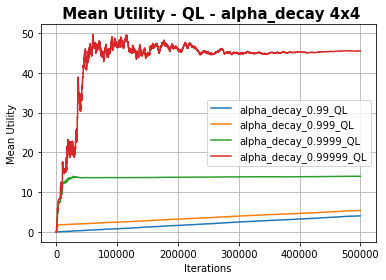

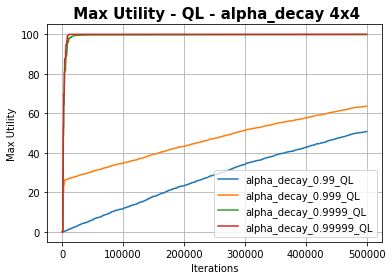

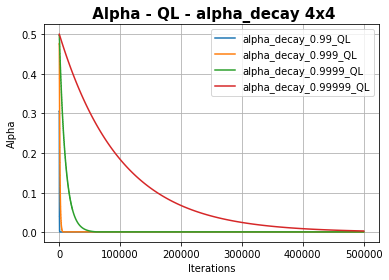

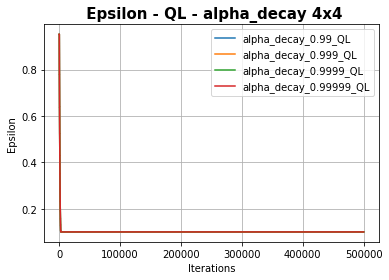

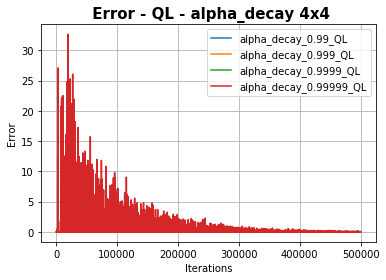

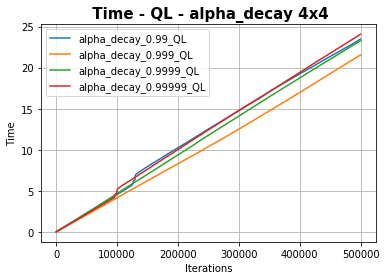

(500000, 40)


In [81]:
results_alpha = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha_decay", param_range = [0.99, 0.999,0.9999, 0.99999], alpha = 0.5)

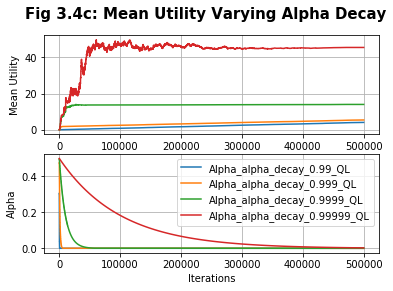

In [85]:
plotIterationGraph(results_alpha, "Mean V", "Alpha", "Fig 3.4c: Mean Utility Varying Alpha Decay")

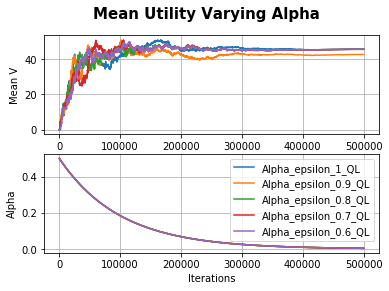

In [78]:
plotIterationGraph(results_epsilon, "Mean V", "Alpha", "Mean Utility Varying Alpha")

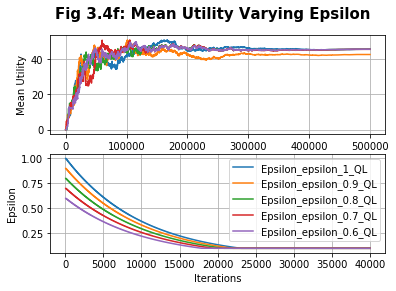

In [92]:
plot1_name = "Mean V"
plot2_name = "Epsilon"
plot1_cols = [col for col in results_epsilon if col.startswith(plot1_name)]
plot2_cols = [col for col in results_epsilon if col.startswith(plot2_name)]
#df[plot1_cols].plot()
fig, axs = plt.subplots(2)
fig.suptitle("Fig 3.4f: Mean Utility Varying Epsilon",fontsize = 15, fontweight = 'heavy')

results_epsilon[plot1_cols].plot(ax= axs[0], legend = False, grid = True)
axs[0].set_ylabel("Mean Utility")

results_epsilon[:40000][plot2_cols].plot(ax= axs[1])
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel(plot2_name)
plt.grid()
plt.show()

(500000, 30)


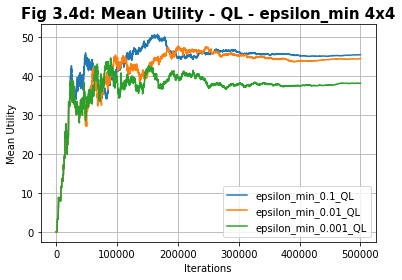

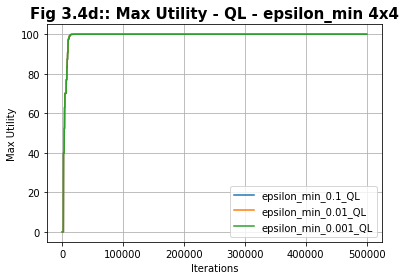

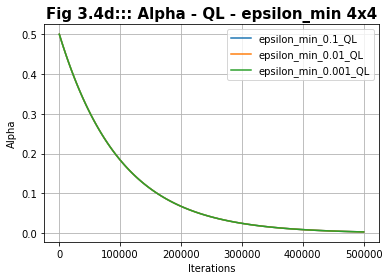

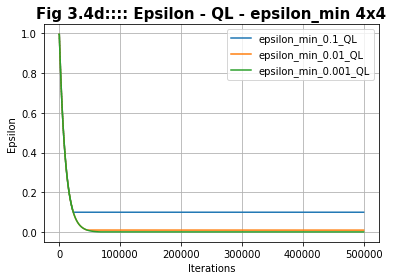

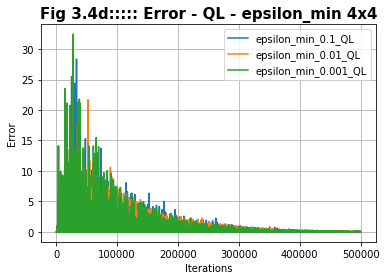

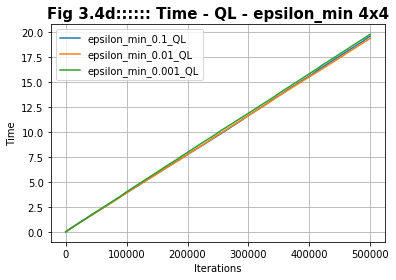

(500000, 30)


In [86]:
results_eps_min = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999, epsilon =1,
                               param = "epsilon_min", param_range = [0.1,0.01,0.001], alpha = 0.5, fig_name="Fig 3.4d")

(500000, 40)


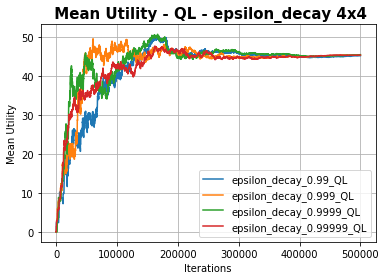

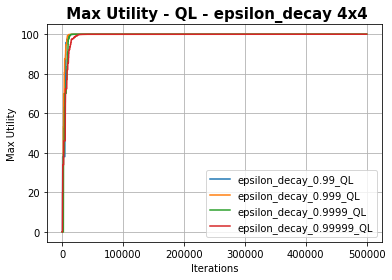

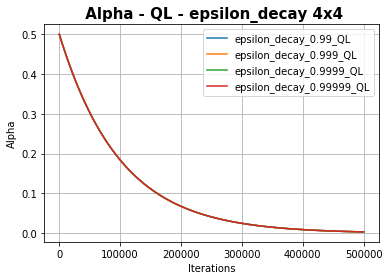

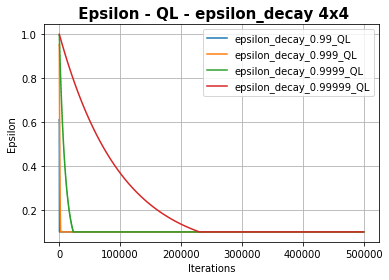

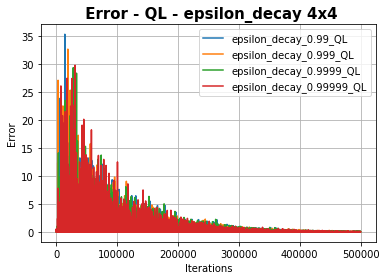

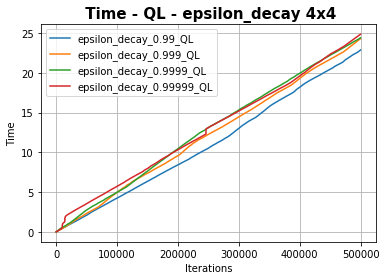

(500000, 40)


In [93]:
results = analyze_param_policy(P_fl, R_fl, solver_type = "Q", max_iter=500000, epsilon = 1, alpha_decay = 0.99999,
                               param = "epsilon_decay", param_range = [0.99, 0.999,0.9999, 0.99999], alpha = 0.5)

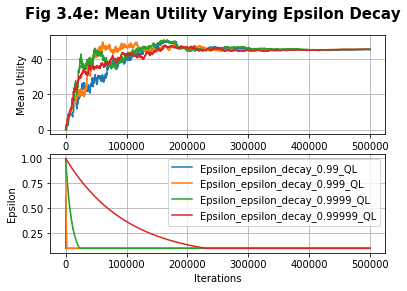

In [98]:
plotIterationGraph(results, "Mean V", "Epsilon", "Fig 3.4e: Mean Utility Varying Epsilon Decay")

In [234]:
np.random.seed(252)
ql = hiive.mdptoolbox.mdp.QLearning(P_fl, R_fl, 0.99, n_iter = 10**6 , epsilon = 1, epsilon_decay = 0.9999,
                               alpha = 0.5, alpha_decay = 0.99999, skip_check=True)
test = ql.run()


(10000, 10)


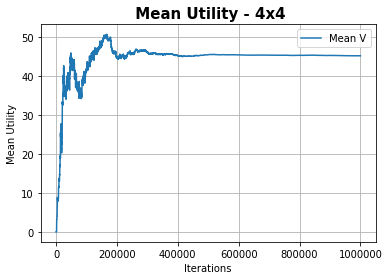

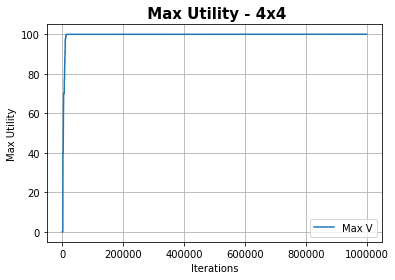

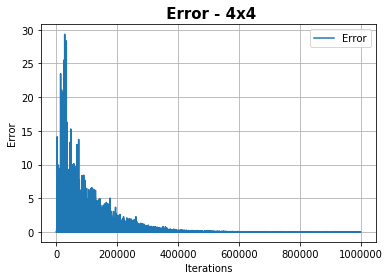

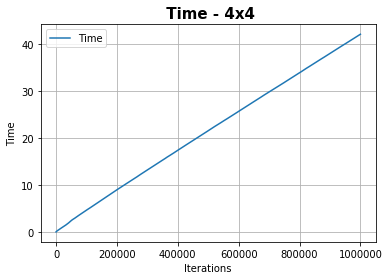

In [95]:
plot_run_stats(ql, "4x4")

(10000, 10)


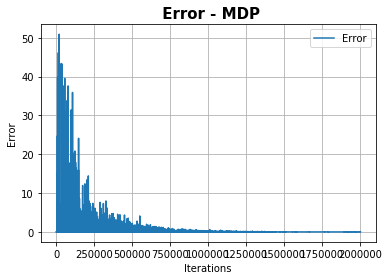

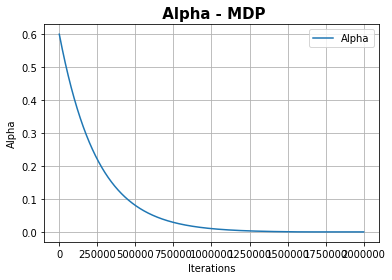

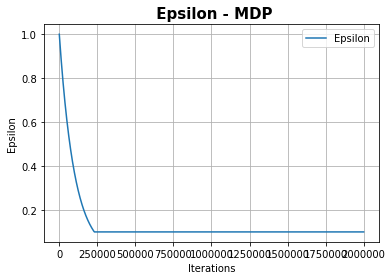

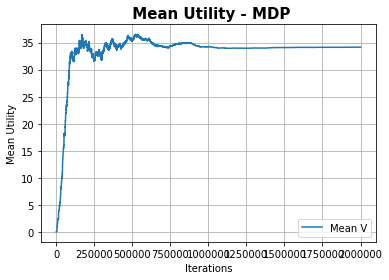

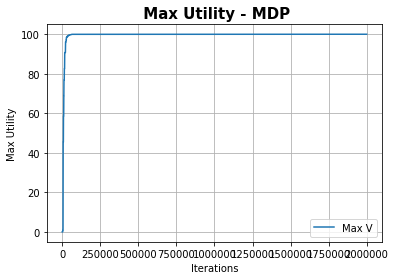

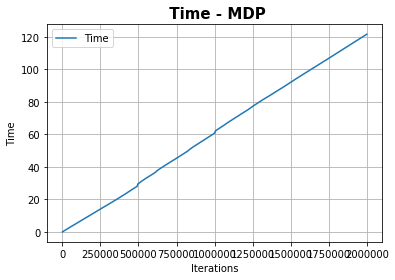

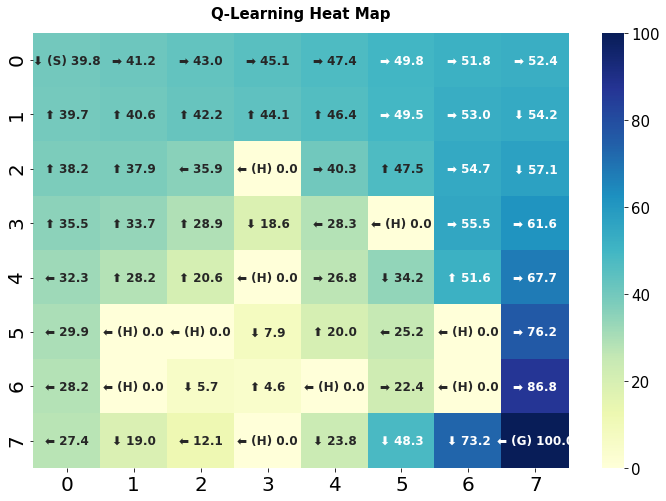

In [96]:
#Selected New
np.random.seed(252)
ql_large = hiive.mdptoolbox.mdp.QLearning(P_fl_large, R_fl_large, 0.99, n_iter = 2000000 , epsilon = 1, epsilon_decay = 0.99999,
                               alpha = 0.6, alpha_decay = 0.999996, skip_check=True)
ql_large.run()
plot_run_stats(ql_large, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
plot_policy_map(ql_large, env_large, "Q-Learning Heat Map", showUtility = True)

# Forest Management

In [99]:
S=500
P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=S, p=0.2, r1 = 5, r2 = 10)

In [228]:
def size_vs_policy():
    li = []
    range_sizes = range(15, 501, 5)
    for i in range_sizes:
        
        P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=i, p=0.2, r1 = 10, r2 = 20)

        pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000)
        pi_fm.run()
        #print(pi_fm.policy)
        li.append(Counter(pi_fm.policy))
    #print(li)
    df = pd.DataFrame(li, index = range_sizes)
    #df[1] = df[0]-1
    df.plot(style = 'x')
    plt.title("Fig 4.1a: Number of Lagging 0s in OP with Size", fontdict={'fontsize': 13, 'fontweight': 'heavy'})
    plt.grid(True)
    plt.xlabel("State #", fontsize=12, fontweight = 'heavy') 
    plt.ylabel("Occurrences", fontsize=12, fontweight = 'heavy')    
    #return df

    
def gamma_vs_policy():
    li = []
    range_gamma = np.linspace(0.01, 0.9, num=50).tolist()
    range_gamma_1 = np.linspace(0.9, 0.999999999, num=50).tolist()
    range_gamma.extend(range_gamma_1)

    #print(range_gamma)
    for i in range_gamma:
        
        P_fm, R_fm, = hiive.mdptoolbox.example.forest(S=500, p=0.2, r1 = 10, r2 = 20)

        pi_fm = hiive.mdptoolbox.mdp.PolicyIteration(P_fm, R_fm, gamma = i, max_iter=1000)
        pi_fm.run()
        #print(pi_fm.policy)
        li.append(Counter(pi_fm.policy))
    #print(li)
    df = pd.DataFrame(li, index =range_gamma)
    df[0] = df[0]-1
    df[[0]].plot(style = '-x')
    plt.title("Fig 4.1b: Number of Lagging 0s in OP with Gamma", fontdict={'fontsize': 13, 'fontweight': 'heavy'})
    plt.grid(True)
    plt.xlabel("State #", fontsize=12, fontweight = 'heavy') 
    plt.ylabel("Lagging 0s", fontsize=12, fontweight = 'heavy')    

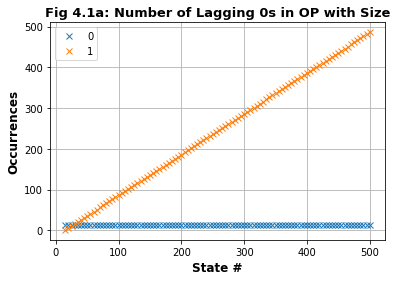

In [227]:
size_vs_policy()

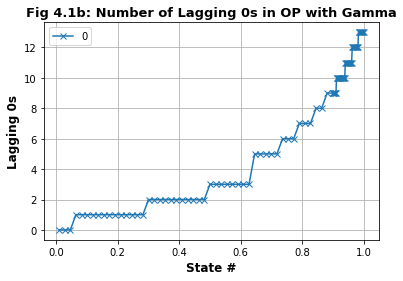

In [229]:
gamma_vs_policy()

## PI

(20, 42)


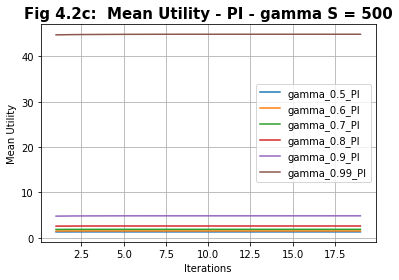

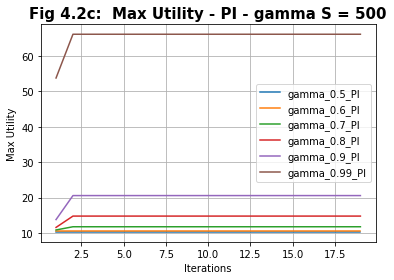

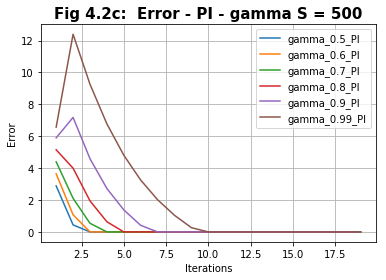

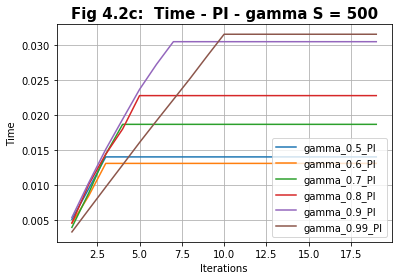

(20, 42)


In [154]:
results = analyze_param_policy(P_fm, R_fm,size = "S = " + str(S), max_iter = 20, param_range = [0.5,0.6,0.7,0.8, 0.9, 0.99], 
                               fig_name="Fig 4.2c: "
                              )

(20, 7)


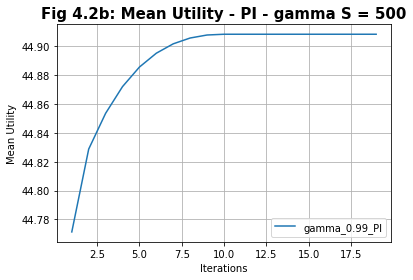

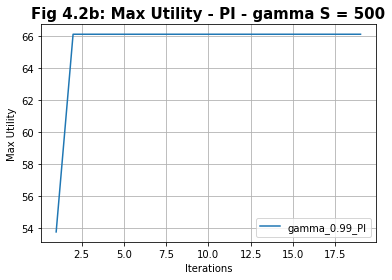

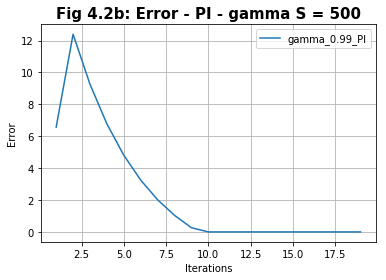

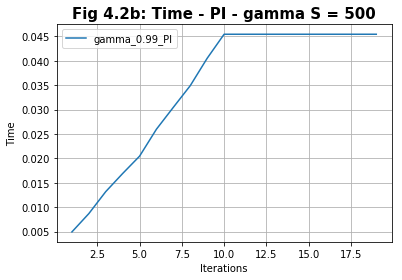

(20, 7)


In [145]:
results = analyze_param_policy(P_fm, R_fm,size = "S = " + str(S), max_iter = 20, param_range = [0.99], fig_name="Fig 4.2b:")

## VI

(500, 56)


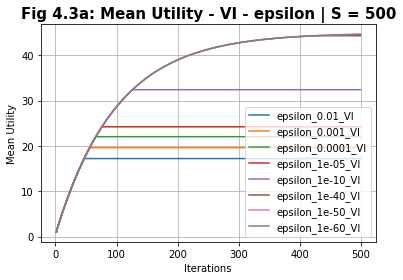

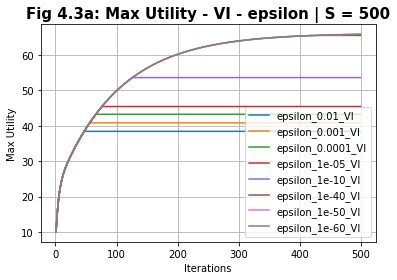

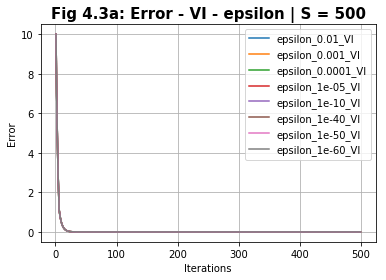

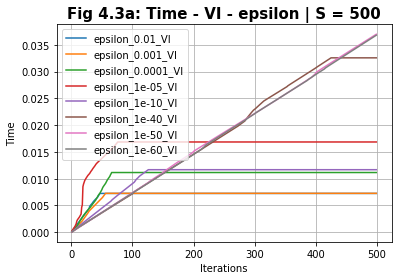

(500, 56)


In [161]:
results = analyze_param_policy(P_fm, R_fm, solver_type = "VI", param = "epsilon", param_range = [0.01,0.001,0.0001,0.00001,1e-10, 1e-40,1e-50, 1e-60],
                              size = "| S = " + str(S), max_iter = 500, fig_name = "Fig 4.3a:")


(1000, 28)


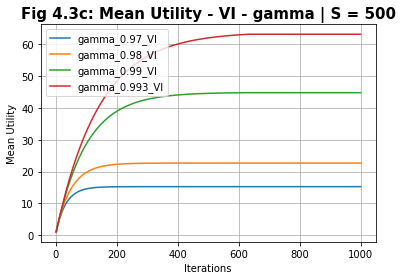

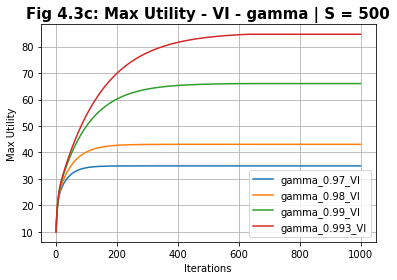

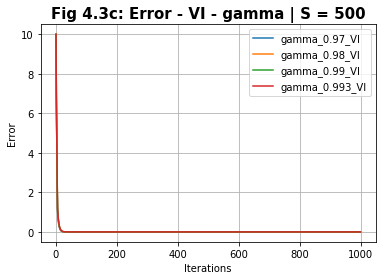

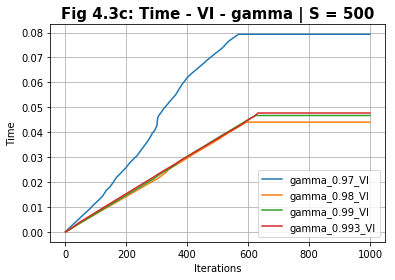

(1000, 28)


In [171]:
results = analyze_param_policy(P_fm, R_fm, solver_type = "VI", size = "| S = " + str(S), max_iter = 1000,epsilon_V = 1e-60, fig_name = "Fig 4.3c:")

In [172]:
vi_fm = hiive.mdptoolbox.mdp.ValueIteration(P_fm, R_fm, gamma = 0.99, max_iter=1000, epsilon=10e-100)
vi_fm.run()
print(vi_fm.policy)
Counter(vi_fm.policy)
print(vi_fm.V)

(0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Text(0.5,1,'Fig 4.4a: Utility Values Per State | S=500')

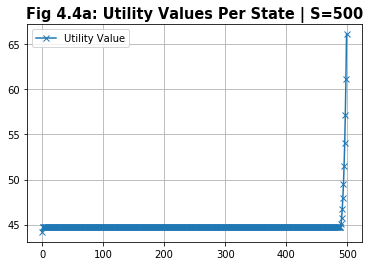

In [179]:
df_values = pd.DataFrame(list(vi_fm.V), columns= ["Utility Value"])
df_values.plot(style = "-x")
plt.grid(True)
plt.title("Fig 4.4a: Utility Values Per State | S=500", fontdict={'fontsize': 14.5, 'fontweight': 'heavy'})

(500000, 40)


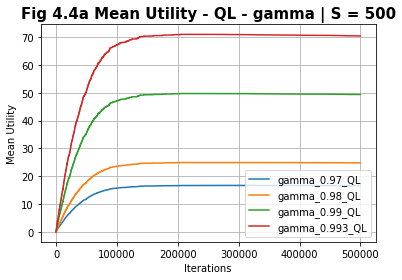

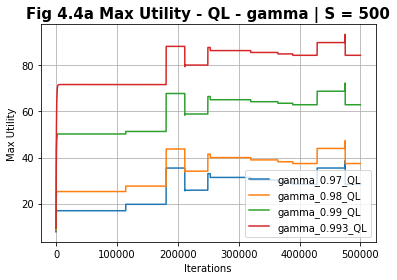

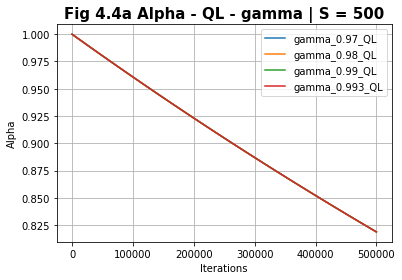

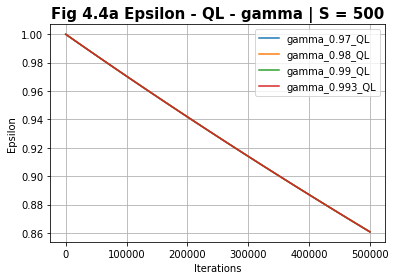

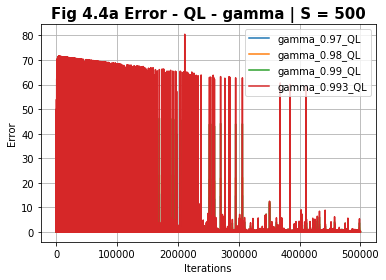

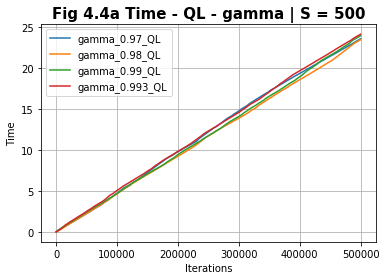

(500000, 40)


In [181]:
results_ql_gamma = analyze_param_policy(P_fm, R_fm, size = "| S = " + str(S), solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.9999997,
                               alpha = 1, alpha_decay = 0.9999996, fig_name = "Fig 4.4a")

(500000, 60)


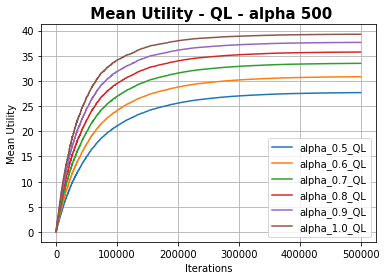

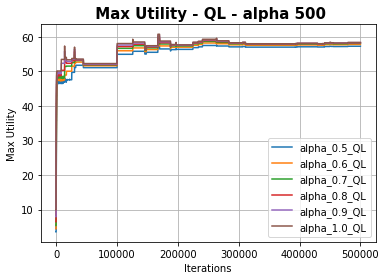

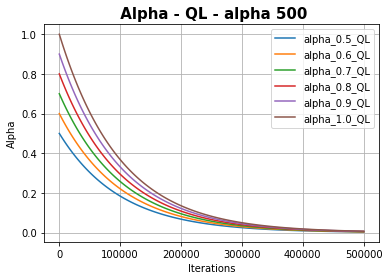

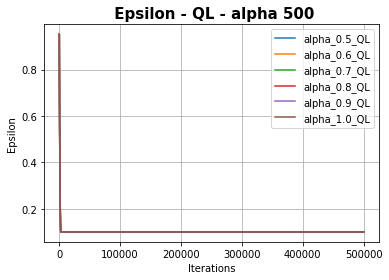

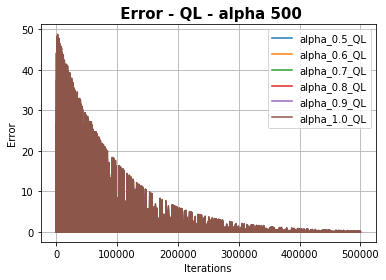

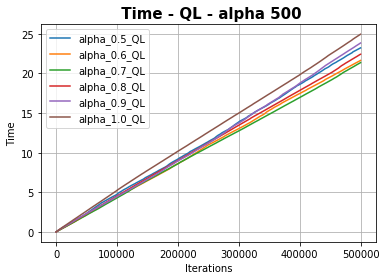

(500000, 60)


In [182]:
results_alpha = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon = 1, epsilon_decay = 0.999,
                               param = "alpha", param_range = [0.5, 0.6,0.7,0.8,0.9,1.0], alpha_decay = 0.99999)

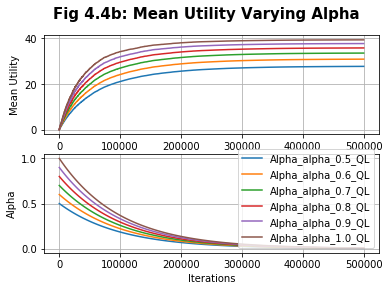

In [189]:
plotIterationGraph(results_alpha, "Mean V", "Alpha", "Fig 4.4b: Mean Utility Varying Alpha")

(5000000, 50)


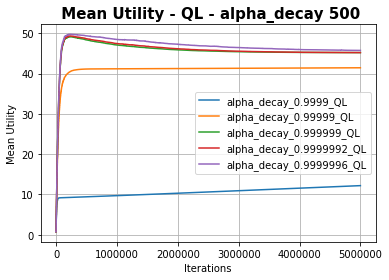

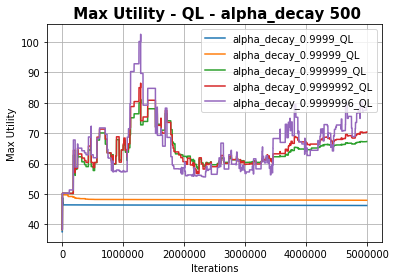

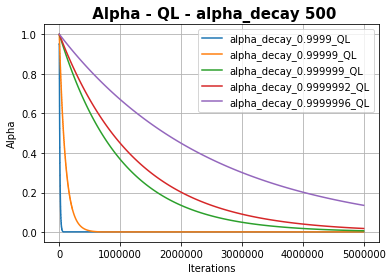

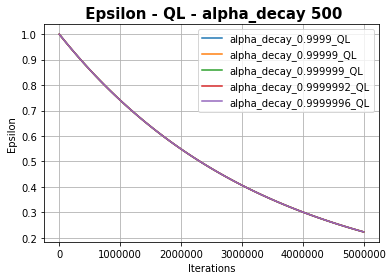

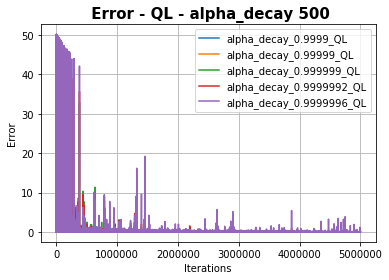

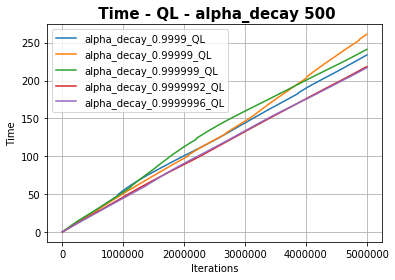

(5000000, 50)


In [184]:
results_alpha_decay = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=5000000, epsilon = 1, epsilon_decay = 0.9999997,
                               param = "alpha_decay", param_range = [0.9999, 0.99999, 0.999999, 0.9999992, 0.9999996], alpha = 1)

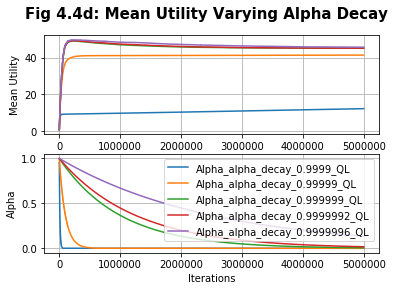

In [196]:
plotIterationGraph(results_alpha_decay, "Mean V", "Alpha", "Fig 4.4d: Mean Utility Varying Alpha Decay")

(5000000, 50)


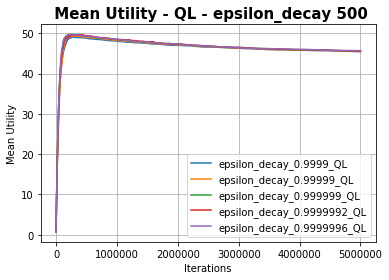

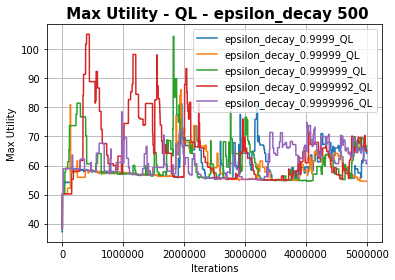

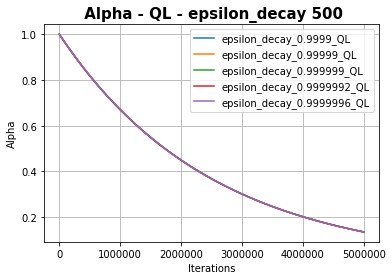

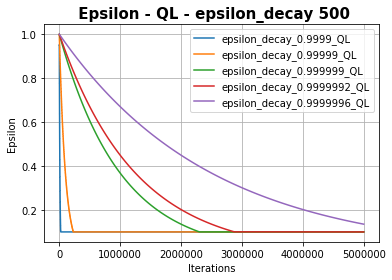

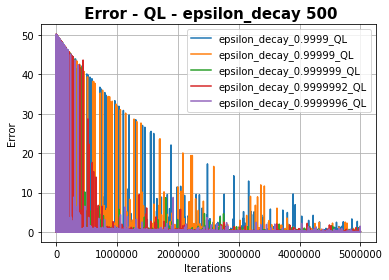

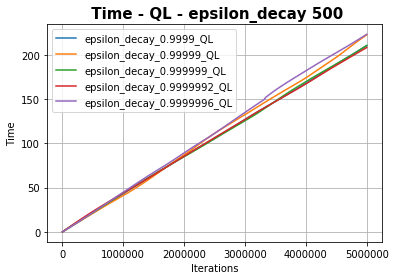

(5000000, 50)


In [186]:
results_epsilon_decay = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=5000000, epsilon = 1, alpha_decay = 0.9999996,
                               param = "epsilon_decay", param_range = [0.9999, 0.99999, 0.999999, 0.9999992, 0.9999996], alpha = 1)

(5000000, 50)


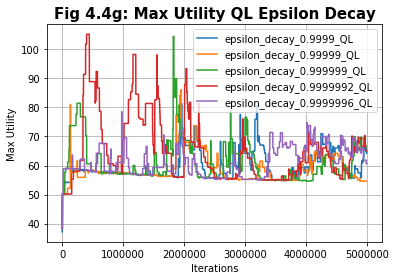

In [209]:
plot_param(results_epsilon_decay, params=["Max V"], title="Fig 4.4g: Max Utility QL Epsilon Decay")

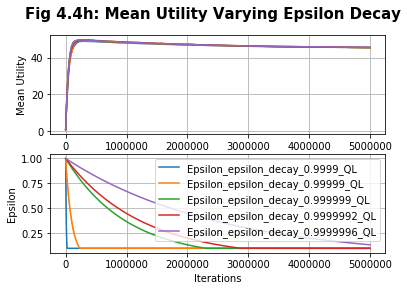

In [199]:
plotIterationGraph(results_epsilon_decay, "Mean V", "Epsilon", "Fig 4.4h: Mean Utility Varying Epsilon Decay")

(5000000, 50)


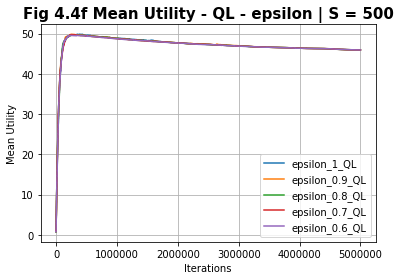

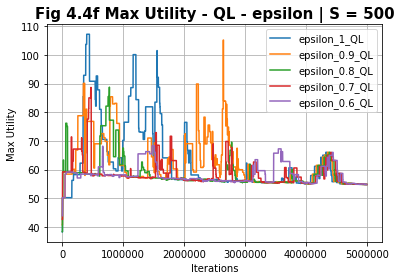

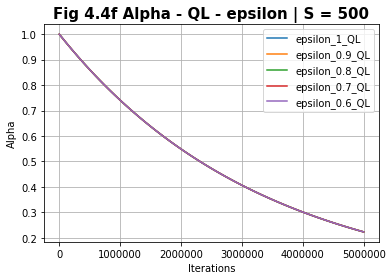

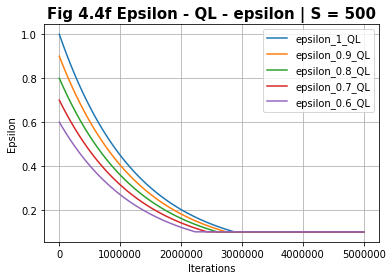

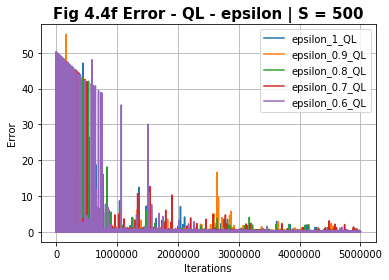

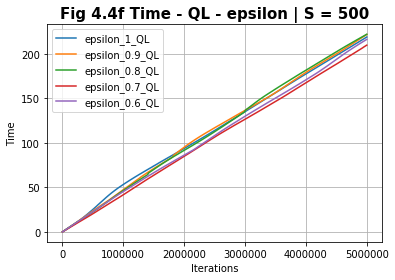

(5000000, 50)


In [188]:
results_epsilon = analyze_param_policy(P_fm, R_fm, size = "| S = " + str(S), solver_type = "Q", max_iter=5000000, epsilon_decay = 0.9999992, alpha_decay = 0.9999997,
                               param = "epsilon", param_range = [1, 0.9, 0.8, 0.7, 0.6], alpha = 1, fig_name= "Fig 4.4f")

(5000000, 50)


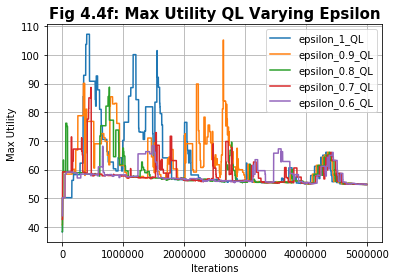

In [230]:
plot_param(results_epsilon, params=["Max V"], title="Fig 4.4f: Max Utility QL Varying Epsilon")

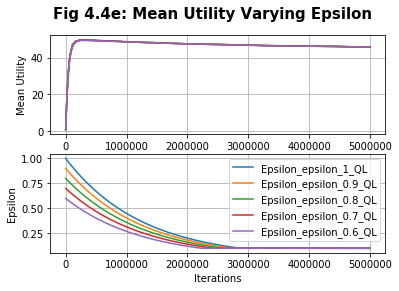

In [198]:
plotIterationGraph(results_epsilon, "Mean V", "Epsilon", "Fig 4.4e: Mean Utility Varying Epsilon")

(500000, 40)


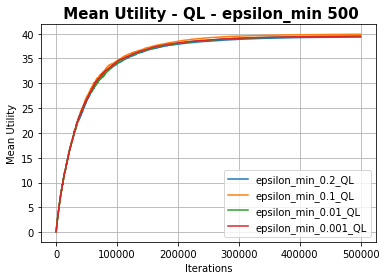

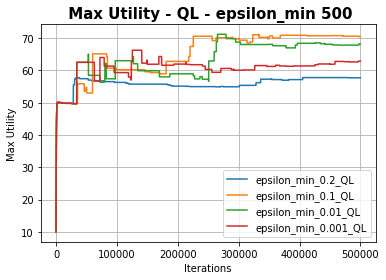

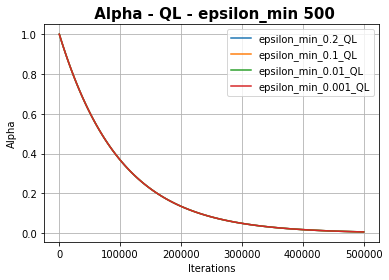

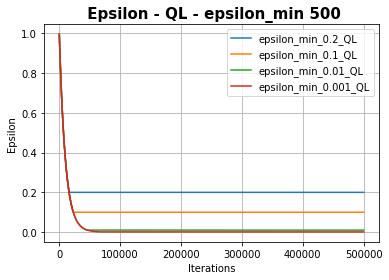

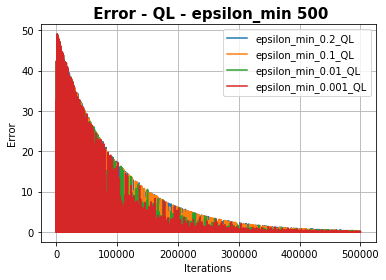

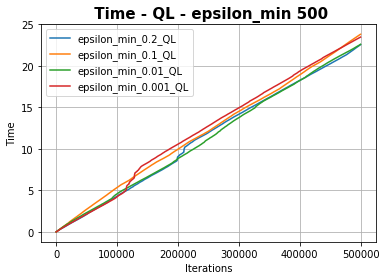

(500000, 40)


In [193]:
results_epsilon_min = analyze_param_policy(P_fm, R_fm, size = str(S), solver_type = "Q", max_iter=500000, epsilon_decay = 0.9999, alpha_decay = 0.99999, epsilon =1,
                               param = "epsilon_min", param_range = [0.2, 0.1,0.01,0.001], alpha = 1)


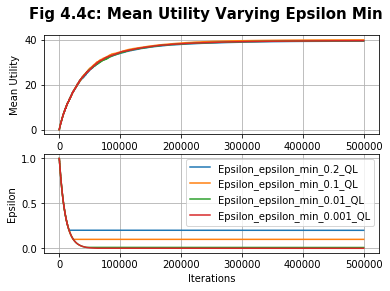

In [195]:
plotIterationGraph(results_epsilon_min, "Mean V", "Epsilon", "Fig 4.4c: Mean Utility Varying Epsilon Min")

(10000, 10)


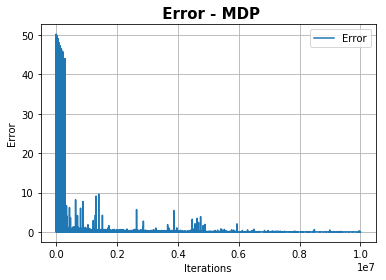

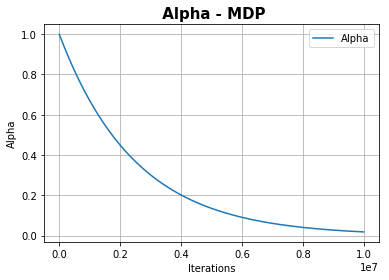

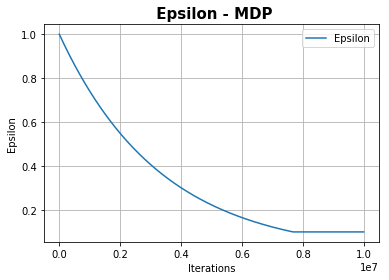

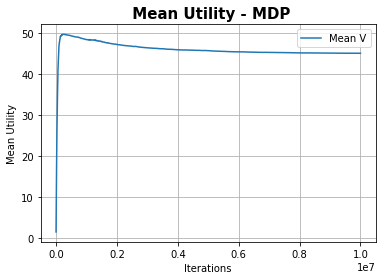

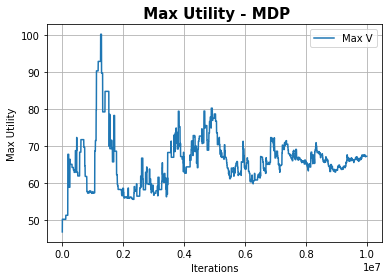

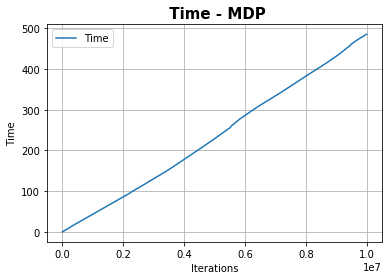

(0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 

Counter({0: 52, 1: 448})

In [192]:
#Selected
np.random.seed(252)
ql_fm = hiive.mdptoolbox.mdp.QLearning(P_fm, R_fm, 0.99, n_iter = 10000000 , epsilon = 1, epsilon_decay = 0.9999997,
                               alpha = 1, alpha_decay = 0.9999996, skip_check=True)
ql_fm.run()
ql_final=plot_run_stats(ql_fm, params = ["Error","Alpha", "Epsilon", "Mean V", "Max V", "Time"])
print(ql_fm.policy)
Counter(ql_fm.policy)

(10000, 10)


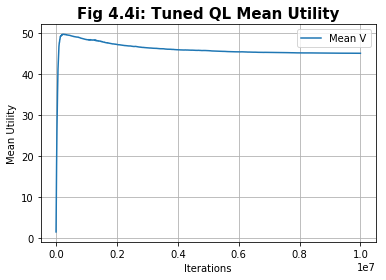

In [213]:
plot_run_stats(ql_fm, params=["Mean V"], title="Fig 4.4i: Tuned QL Mean Utility")

(10000, 10)


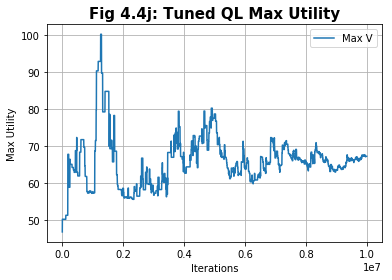

In [215]:
plot_run_stats(ql_fm, params=["Max V"], title="Fig 4.4j: Tuned QL Max Utility")

(10000, 10)


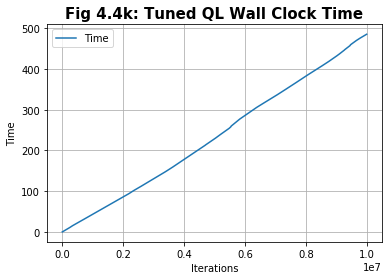

In [218]:
plot_run_stats(ql_fm, params=["Time"], title="Fig 4.4k: Tuned QL Wall Clock Time")

In [ ]:
def plot_policy_map_fm(trained_policy, title = "Heat Map", showUtility = False, dimensions = (20,25)):
    policy = trained_policy.policy
    V = trained_policy.V
    # Plot heatmap
    
    policy_map = zip(policy)
    labels = []
    font_size = 20
#     for policy, utility in policy_map:
#         annot = ""
#         if policy == 0:
#             annot = directions_lake()[policy] + " (S)"
#         elif square == b'H':
#             annot = directions_lake()[policy] + " (H)"
#         elif square == b'G':
#             annot = directions_lake()[policy] + " (G)"
#         else:
#             annot = directions_lake()[policy]
#         if showUtility:
#             font_size = 12
#             annot = annot + " " + str('%.1f' % utility)
#         labels.append(annot)
            
#     length = int(math.sqrt(len(labels)))
#     labels = np.array(labels).reshape(length,length)

    fig, ax = plt.subplots(figsize=(8, 6))
    #g = sns.heatmap(np.array(policy).reshape(15, 1), cmap="YlGnBu", annot=labels, fmt = '', annot_kws={"size":font_size, "fontweight":'heavy'}, ax = ax)
    array =np.array(policy).reshape(dimensions[0], dimensions[1])
    g = sns.heatmap(array, ax = ax, linewidths=0.2, linecolor='black', cbar= False)
    ax.tick_params(labelsize=12)
    #cax = plt.gcf().axes[-1]
    #cax.tick_params(labelsize=15)
    plt.title(title, y = 1.02, fontsize=15, fontweight ='heavy')
    for _, spine in ax.spines.items():
        spine.set_visible(True)
    plt.show()

In [ ]:
plot_policy_map_fm(ql_fm, title = "QL: S = 500 Policy Map (Black = Wait, White = Cut)")
